In [0]:
##Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

In [0]:
!ls

sample_data


In [0]:
##importing from local machine 
from google.colab import files
files.upload()

Saving question-pairs-dataset.zip to question-pairs-dataset.zip


#EDA

In [0]:
##unzipping the dataset
!unzip question-pairs-dataset.zip

Archive:  question-pairs-dataset.zip
  inflating: questions.csv           


In [0]:
##Loading the training data
data = pd.read_csv("questions.csv")
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
##checking for missing data
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [0]:
## deleting the columns containing the missing data
data = data.dropna()
data.shape

(404348, 6)

In [0]:
##imspecting the labels 
data['is_duplicate'].value_counts(normalize = True)
##we have imbalanced dataset

0    0.630749
1    0.369251
Name: is_duplicate, dtype: float64

In [0]:
##checking for duplicate entries
data = data.drop_duplicates()

##No duplicate entries

In [0]:
##inspecting the unique questions.
unique_questions = len(np.unique(np.append(data['qid2'],data['qid2'])))
print("the number of uniqe questions in the dataset is {}".format(unique_questions))

the number of uniqe questions in the dataset is 397938


In [0]:
## % of repeated questions in the dataset
print("% of repeated questions are:--{}".format((1-unique_questions/data.shape[0])*100))


% of repeated questions are:--1.585268135368545


Text(0.5, 1.0, 'IDS with repeated questions')

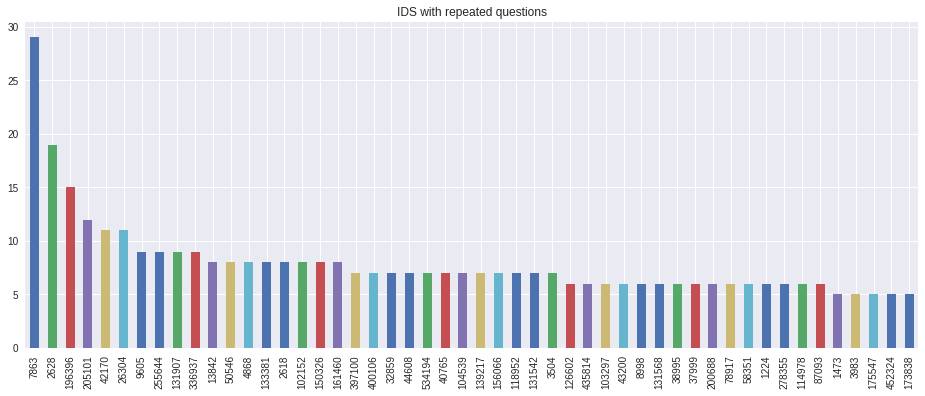

In [0]:
##which of the question ids were repeated
data['qid1'].value_counts()[:50].plot(kind = 'bar',figsize = (16,6))
plt.title("IDS with repeated questions")

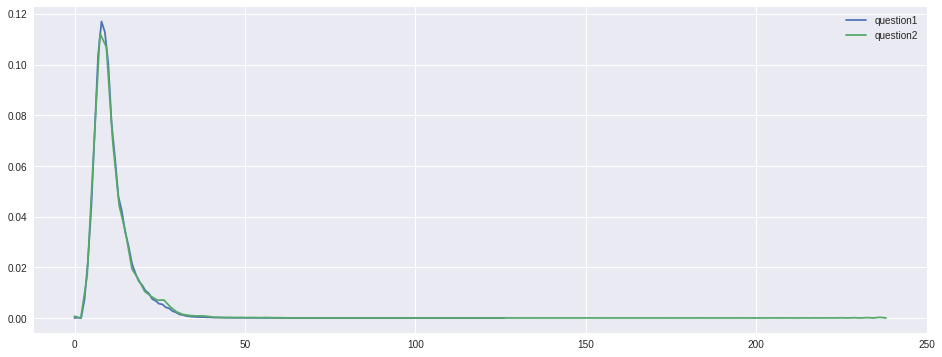

In [0]:
##Inspecting the word count per questions:--
word_count_id1 = data['question1'].map(lambda x: len(x.split()))
word_count_id2 = data['question2'].map(lambda x: len(x.split()))

##plotting the distribution
plt.figure(figsize = (16,6))
sns.kdeplot(word_count_id1,label = 'question1')
sns.kdeplot(word_count_id2,label = 'question2')
plt.legend()
##Both of them have similar distribution.

Text(0, 0.5, 'distribution')

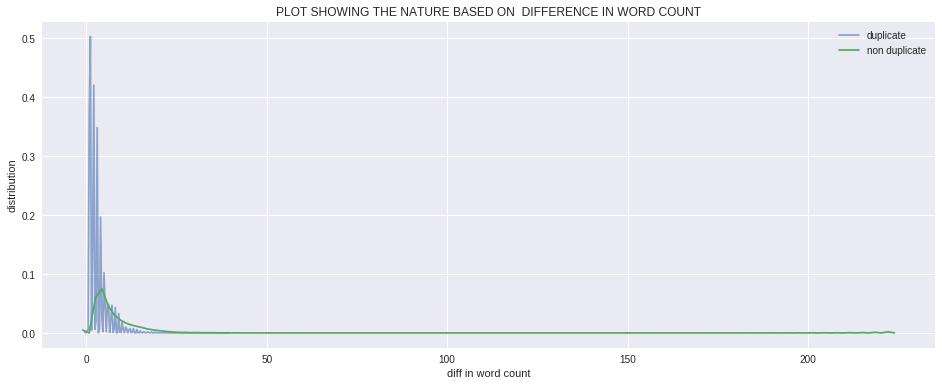

In [0]:
##Plotting the distribution based on the label
diff_count = abs(word_count_id1-word_count_id2)
plt.figure(figsize = (16,6))
sns.kdeplot(diff_count.loc[(data['is_duplicate'] == 1)],alpha = 0.6,label = 'duplicate')
sns.kdeplot(diff_count.loc[(data['is_duplicate'] == 0)],label = 'non duplicate')
plt.legend()
plt.title('PLOT SHOWING THE NATURE BASED ON  DIFFERENCE IN WORD COUNT')
plt.xlabel("diff in word count")
plt.ylabel("distribution")

##Thus it can be concluded that if the difference in the word counts of respective questions are more then certain threshold then 
##the chances of being duplicate is heigher.

# BASELINE MODEL -1

This model is based on the word count in the respective questions.  
Metrices used is f1-score

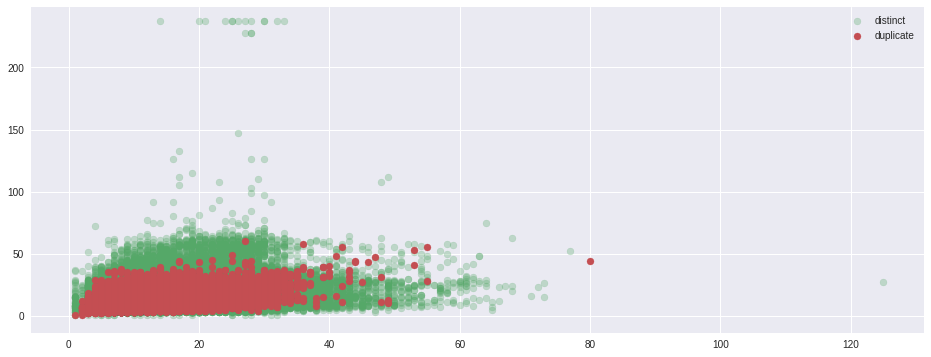

In [0]:
##plotting the scatter plot to see the distribution
data['count1'] = word_count_id1
data['count2'] = word_count_id2

plt.figure(figsize = (16,6))
plt.scatter(data['count1'].loc[(data['is_duplicate'] == 0)],data['count2'].loc[(data['is_duplicate'] == 0)],color = 'g',alpha = 0.3,label = 'distinct')
plt.scatter(data['count1'].loc[(data['is_duplicate'] == 1)],data['count2'].loc[(data['is_duplicate'] == 1)],color = 'r',label = 'duplicate')
plt.legend()

In [0]:
##Modelling with logistic regression
x = data[['count1','count2']].values
y = data['is_duplicate'].values

##calling standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

##calling train_test_split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.20,stratify = y,random_state = 22)

##fittting the logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(x_train,y_train)

##prediction
y_pred = lr.predict(x_val)

##getting the accuracy score
from sklearn.metrics import accuracy_score
lr_score = accuracy_score(y_val,y_pred)*100
print(lr_score)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


62.235686904909116


Thus received a total of 62.23% accuracy on the validation data.

#Advanced Text Preprocessing   

In this secton I am going ot use GloVe pretrained word vectors for training the model.  


In [0]:
##loading the glove module
##importing google colab essentials:--
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
##Authentication

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 7.5MB/s 


In [0]:
##getting the data
##downloading the zip file from the cloud
fid = drive.ListFile({'q':"title='glove.6B.100d.txt'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('glove.txt')

In [0]:
##creting the embedding index
f = open('glove.txt')
embedding_index = {}
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:],
                    dtype = 'float32')
  embedding_index[word] = coefs
  
f.close()

In [0]:
##processing....

##this gives progress bar
from tqdm import tqdm

##building the vocab of words
def build_vocab(sentences,verbose = True):
  vocab = {}
  for sentence in tqdm(sentences,disable = (not verbose)):
    for word in sentence:
      try:
        vocab[word] += 1
      except KeyError:
        vocab[word] = 1
  return vocab
  

In [0]:
##Building the sentences out og the questions:--
sent_q1 = data['question1'].map(lambda z: z.split())
sent_q2 = data['question2'].map(lambda z: z.split())

In [0]:
##getting the complete sentence
sentences = pd.concat([sent_q1,sent_q2])

In [0]:
##creating the vocab
vocab_step1 = build_vocab(sentences)

100%|██████████| 808696/808696 [00:02<00:00, 273476.78it/s]


In [0]:
##checking the intersection of our vocab and the embeddings
import operator
def check_coverage(vocab,embedding_index):
  a = {}
  oov = {}
  k = 0
  i = 0
  for word in tqdm(vocab):
    try:
      a[word] = embedding_index[word]
      k += vocab[word]
    except:
      oov[word] = vocab[word]
      i += vocab[word]
      pass
  print()  
  print("found embeddings for {} % of vocab".format((len(a)/len(vocab))*100))
  print("found embeddings for {} % of all texts".format((k/(k+i))*100))
  
  sorted_x = sorted(oov.items(),key = operator.itemgetter(1))[::-1]
  return sorted_x

oov  = check_coverage(vocab_step1,embedding_index)


100%|██████████| 232563/232563 [00:00<00:00, 731770.57it/s]


found embeddings for 18.264298276166027 % of vocab
found embeddings for 68.83484336776712 % of all texts


In [0]:
oov[:20]

[('What', 292760),
 ('I', 211550),
 ('How', 201477),
 ('Why', 69610),
 ('Is', 52573),
 ('Which', 36288),
 ('Can', 25889),
 ('If', 16295),
 ('Who', 15945),
 ('Do', 15230),
 ('India?', 15003),
 ('Where', 14018),
 ('Does', 12105),
 ("What's", 11889),
 ('Are', 10482),
 ('India', 10377),
 ('Indian', 9905),
 ('Quora', 8789),
 ('Quora?', 8376),
 ('Should', 7957)]

In [0]:
##so we have general things included in oov 
##inspection
'what' in embedding_index

##there is problem with the capitalization of the words.

True

In [0]:
##Building the sentences out og the questions:--
data['question1'] = data['question1'].map(lambda z : z.lower())
sent_q1 = data['question1'].map(lambda z: z.split())
data['question2'] = data['question2'].map(lambda z : z.lower())
sent_q2 = data['question2'].map(lambda z: z.split())

In [0]:
##getting the complete sentence
sentences = pd.concat([sent_q1,sent_q2])
##creating the vocab
vocab = build_vocab(sentences)
##checking the coverage
oov  = check_coverage(vocab,embedding_index)

100%|██████████| 201113/201113 [00:00<00:00, 745958.44it/s]



found embeddings for 28.185646875139845 % of vocab
found embeddings for 86.5124135014484 % of all texts


In [0]:
##as the percentage has increases so lets investigae more
oov[:10]

[('india?', 16165),
 ("what's", 12342),
 ('quora?', 8479),
 ('why?', 7927),
 ('life?', 7797),
 ("don't", 7773),
 ('it?', 6778),
 ("i'm", 6101),
 ('do?', 5821),
 ('time?', 4609)]

In [0]:
##It seems that we have problem with punctuations:--
def clean_text(x):
  x = str(x)
  for punct in '/-':
    x = x.replace(punct,'')
  for punct in '&':
    x = x.replace(punct,f'{punct}')
    
  for punct in "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–':
    x = x.replace(punct,'')
    
  return x


In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [0]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known
  


In [0]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text


In [0]:
known_contractions(embedding_index)

["'cause", "ma'am", "o'clock"]

In [0]:
data['treated_question1'] = data['question1'].apply(lambda x: clean_contractions(x, contraction_mapping))
data['treated_question1'] = data['treated_question1'].apply(lambda x: clean_text(x))
data['treated_question2'] = data['question2'].apply(lambda x: clean_contractions(x, contraction_mapping))
data['treated_question2'] = data['treated_question2'].apply(lambda x: clean_text(x))
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,treated_question1,treated_question2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water


In [0]:
##Building the sentences out og the questions:--
sent_q1 = data['treated_question1'].map(lambda z: z.split())
sent_q2 = data['treated_question2'].map(lambda z: z.split())

##getting the complete sentence
sentences = pd.concat([sent_q1,sent_q2])
##creating the vocab
vocab = build_vocab(sentences)
##checking the coverage
oov  = check_coverage(vocab,embedding_index)

100%|██████████| 109546/109546 [00:00<00:00, 777912.29it/s]



found embeddings for 56.268599492450655 % of vocab
found embeddings for 98.7620034777698 % of all texts


In [0]:
'of' in embedding_index

True

In [0]:
mispel_dict = {
    'kvpy':'science exam','hillstation':'hill station','ibps':'fertilization technology','redmi':'smartphone','paytm':'company',
    'flipkart':'company','hisher':'his her','demonetization':'non monetization','brexit':'britain exit','manaphy':'pokemon',
    'heshe':'he she','firsttime':'first time','upvotes':'up votes','officejet':'printer name','4620':'version','airprint':'air print',
    'quorans':'quora users','quora':'question and answer website','quoras':'quora','aadhar':'identity card','demoetizing':'non monitizing',
    'wechat':'social media','facebooks':'social media','imessage':'social media','upvoted':'up voted','cpec':'development project',
    'ntse':'exam','iitjee':'engineering exam','wbjee':'engineering exam','aipmt':'medical exam','oneplus':'smartphone','laymans':'lay mans',
    'angularjs':'website designing platform','nodejs':'programming platform','delhincr':'neighbour of delhi','bitsat':'engineering exam',
    'snapdeal':'company','amcat':'exam','fiitjee':'coaching institute','littleknown':'little known','upvote':'up vote','presidentelect':
    'president elect','himher':'him her','aspergers':'medical disorder','selfesteem':'self esteem','viber':'software','tshirts':'shirt',
    'exgirlfriend':'previous girl friend','venezuelas':'venezuela','articleship':'article ship','isare':'is are','urjit':'name','tshirt':
    'shirt','magento':'software','udemy':'online learning platform','wifes':'wife','zenphone':'smartphone',
    'demonetisation':'non monetization','demonetize':'non moentization','tatkal':'instant','5001000':'version','lesserknown':'lesser known',
    'demonetizing':'non monetization','aadhaar':'id','fengineering':'engineering','omegle':'social media','ww3':'world war 3'
}

In [0]:
'id' in embedding_index

True

In [0]:
def rectified(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [0]:
data['treated_question1'] = data['treated_question1'].apply(lambda x: rectified(x,mispel_dict))
data['treated_question2'] = data['treated_question2'].apply(lambda x: rectified(x,mispel_dict))

In [0]:
##recheking the coverage:--
##Building the sentences out og the questions:--
sent_q1 = data['treated_question1'].map(lambda z: z.split())
sent_q2 = data['treated_question2'].map(lambda z: z.split())

##getting the complete sentence
sentences = pd.concat([sent_q1,sent_q2])
##creating the vocab
vocab = build_vocab(sentences)
##checking the coverage
oov  = check_coverage(vocab,embedding_index)
##we reached almost 99%.

100%|██████████| 109461/109461 [00:00<00:00, 736417.26it/s]



found embeddings for 56.306812472021996 % of vocab
found embeddings for 98.89684197401385 % of all texts


#Model Building  
we are going to use lstm in our model.

In [0]:
import keras

q1 = data['treated_question1'].values
q2 = data['treated_question2'].values

##text preprocessing for keras
from keras.preprocessing.text import Tokenizer

tokenizer_q1 = Tokenizer(num_words = max_words,lower = True,oov_token = 'UNK')
tokenizer_q1.fit_on_texts(q1)
word_ids_q1 = tokenizer_q1.word_index

tokenizer_q2 = Tokenizer(num_words = max_words,lower = True,oov_token = 'UNK')
tokenizer_q2.fit_on_texts(q2)
word_ids_q2 = tokenizer_q2.word_index


print(word_ids_q1)
print()
print(word_ids_q2)

Using TensorFlow backend.


{'UNK': 1, 'the': 2, 'what': 3, 'is': 4, 'how': 5, 'i': 6, 'a': 7, 'to': 8, 'in': 9, 'do': 10, 'of': 11, 'and': 12, 'are': 13, 'can': 14, 'for': 15, 'you': 16, 'why': 17, 'it': 18, 'best': 19, 'my': 20, 'on': 21, 'does': 22, 'which': 23, 'or': 24, 'have': 25, 'if': 26, 'be': 27, 'some': 28, 'that': 29, 'with': 30, 'get': 31, 'should': 32, 'not': 33, 'an': 34, 'from': 35, 'your': 36, 'will': 37, 'india': 38, 'when': 39, 'who': 40, 'like': 41, 'people': 42, 'at': 43, 'good': 44, 'question': 45, 'there': 46, 'would': 47, 'website': 48, 'between': 49, 'as': 50, 'answer': 51, 'about': 52, 'did': 53, 'one': 54, 'most': 55, 'we': 56, 'make': 57, 'where': 58, 'by': 59, 'way': 60, 'am': 61, 'was': 62, 'any': 63, 'they': 64, 'so': 65, 'life': 66, 'difference': 67, 'after': 68, 'me': 69, 'money': 70, 'this': 71, 'time': 72, 'has': 73, 'know': 74, 'learn': 75, 'much': 76, 'new': 77, 'their': 78, 'use': 79, 'many': 80, 'think': 81, 'someone': 82, 'find': 83, 'all': 84, 'indian': 85, 'ever': 86, 'th

In [0]:
##converting the training data to the sequence of word indices:
seq_q1 = tokenizer_q1.texts_to_sequences(q1)
seq_q2  = tokenizer_q2.texts_to_sequences(q2)

In [0]:
##padding the semtences so as to make them equal sized.
from keras.preprocessing.sequence import pad_sequences
maximum_sequence_length = 40
data_q1 = pad_sequences(seq_q1,40)
data_q2 = pad_sequences(seq_q2,40)

In [0]:
##creatig the embedding matrix
embedding_dim = 100
embedding_matrix_q1 = np.zeros(shape = (len(word_ids_q1)+1,embedding_dim))

for word,i in word_ids_q1.items():
  embedding_vector_q1 = embedding_index.get(word)
  if embedding_vector_q1 is not None:
    # words not found will be all 0s
    embedding_matrix_q1[i] = embedding_vector_q1
    
##for question 2
embedding_matrix_q2 = np.zeros(shape = (len(word_ids_q2)+1,embedding_dim))

for word,i in word_ids_q2.items():
  embedding_vector_q2 = embedding_index.get(word)
  if embedding_vector_q2 is not None:
    # words not found will be all 0s
    embedding_matrix_q2[i] = embedding_vector_q2

In [0]:
##creating the labels:--
labels = np.array(data['is_duplicate'], dtype=int)

In [0]:
##Validating
print('Shape of question1 data tensor:', data_q1.shape)
print('Shape of question2 data tensor:', data_q2.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (404348, 40)
Shape of question2 data tensor: (404348, 40)
Shape of label tensor: (404348,)


In [0]:
##Partitioning the dataset in to train and test 
X = np.stack((data_q1,data_q2), axis=1)
y = labels

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,random_state = 22)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [0]:
##Defining the model hyperparameters
MAX_SEQUENCE_LENGTH = 40
EMBEDDING_DIM = 100
OPTIMIZER = 'adam'
MAX_WORDS = 200000
DROPOUT = 0.3
MAX_WORDS_Q1 = min(MAX_WORDS, len(word_ids_q1))
MAX_WORDS_Q2 = min(MAX_WORDS, len(word_ids_q2))
NB_EPOCHS = 25
BATCH_SIZE = 32
MODEL_WEIGHT_FILE  = 'weights.h5'
VALIDATION_SPLIT = 0.09

In [0]:
##Imports
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K



# Define the model
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(MAX_WORDS_Q1 + 1, 
                 EMBEDDING_DIM, 
                 weights=[embedding_matrix_q1], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(MAX_WORDS_Q2 + 1, 
                 EMBEDDING_DIM, 
                 weights=[embedding_matrix_q2], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

merged = concatenate([q1,q2])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 100)      8129300     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 100)      7639200     input_4[0][0]                    
__________________________________________________________________________________________________
time_distr

In [0]:
callbacks = [ModelCheckpoint(MODEL_WEIGHT_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
callbacks=callbacks)

Train on 275967 samples, validate on 27294 samples
Epoch 1/25
 - 125s - loss: 0.5842 - acc: 0.6957 - val_loss: 0.5322 - val_acc: 0.7351
Epoch 2/25
 - 124s - loss: 0.5276 - acc: 0.7377 - val_loss: 0.5055 - val_acc: 0.7427
Epoch 3/25
 - 124s - loss: 0.5101 - acc: 0.7478 - val_loss: 0.4965 - val_acc: 0.7517
Epoch 4/25
 - 124s - loss: 0.4967 - acc: 0.7558 - val_loss: 0.4792 - val_acc: 0.7618
Epoch 5/25
 - 124s - loss: 0.4891 - acc: 0.7609 - val_loss: 0.4882 - val_acc: 0.7590
Epoch 6/25
 - 124s - loss: 0.4830 - acc: 0.7645 - val_loss: 0.4808 - val_acc: 0.7606
Epoch 7/25
 - 124s - loss: 0.4753 - acc: 0.7708 - val_loss: 0.4752 - val_acc: 0.7658
Epoch 8/25
 - 124s - loss: 0.4718 - acc: 0.7728 - val_loss: 0.4896 - val_acc: 0.7521
Epoch 9/25


In [0]:
##pLOTTING 

acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [0]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

In [0]:
model.load_weights(MODEL_WEIGHT_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))